In [1]:
import requests
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import mlab
import seaborn as sns
import pandas as pd
from scipy import stats
sns.set_palette("husl")
%matplotlib inline

In [2]:
#Url of the phageParser API
apiurl = 'http://127.0.0.1:8000'
#Get the initial page for listing of accessible objects and get url for organisms and casproteins
url_json=requests.get(apiurl).json()
organisms_url = url_json['organisms']
cas_proteins_url = url_json['casproteins']
oselfspacer_url = url_json['organismselfspacers']

In [4]:
#Iterate through each page and merge the json response into a dictionary for cas proteins
cas_protein_dict = {}
r=requests.get(cas_proteins_url)
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = cas_proteins_url+'?page={}'.format(page)
    payload = requests.get(url).json()
    cas_protein_objs = payload['cas_proteins']
    for cas_protein_obj in cas_protein_objs:
        cas_protein_dict[cas_protein_obj['id']] = cas_protein_obj

In [5]:
#Iterate through each page and merge the json response into a dictionary for organisms
organism_dict = {}
r=requests.get(organisms_url)
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = organisms_url+'?page={}&include[]=cas_proteins&include[]=loci.spacers'.format(page)
    payload = requests.get(url).json()
    organism_objs = payload['organisms']
    for organism_obj in organism_objs:
        organism_dict[organism_obj['id']] = organism_obj

In [6]:
#Make a set of specific cas proteins by grouping them from gene field
cas3_proteins = {k: v for k, v in cas_protein_dict.items() if 'cas3' in v['gene']}
cas9_proteins = {k: v for k, v in cas_protein_dict.items() if 'cas9' in v['gene']}
cas10_proteins = {k: v for k, v in cas_protein_dict.items() if 'cas10' in v['gene']}

In [32]:
#Convert dictionary to dataframe with added annotations
org_df={}
loc_df={}
for k,v in organism_dict.items():
    org = {'accession':v['accession'], 'name':v['name'], 'CRISPR_type':'','single_spacer':False}
    if v['cas_proteins']:
        org_proteins = set(v['cas_proteins'])
        if not org_proteins.isdisjoint(cas3_proteins): #has cas3 proteins
            org['CRISPR_type'] += 'Type I'
        if not org_proteins.isdisjoint(cas9_proteins): #has cas9 proteins
            org['CRISPR_type'] += 'Type II'
        if not org_proteins.isdisjoint(cas10_proteins): #has cas10 proteins
            org['CRISPR_type'] += 'Type III'
    if v['loci']:
        if all([len(loc['spacers']) < 2 for loc in v['loci']]):
            org['single_spacer'] = True
    for locus in v['loci']:
        loc = {'org_id':k, 'num_spacers':len(locus['spacers'])}
        spacerlens = [spacer['length'] for spacer in locus['spacers']]
        avg_spacerlens = sum(spacerlens)/len(spacerlens)
        loc['avg_spacerlens'] = avg_spacerlens
        loc_df[locus['id']] = loc
    org_df[k] = org
loc_df = pd.DataFrame.from_dict(loc_df, orient='index')
org_df = pd.DataFrame.from_dict(org_df, orient='index')

In [87]:
a=loc_df[loc_df['num_spacers'] == 1].copy() #loci with one spacers
a['single_spacer_organism'] = org_df.loc[a.org_id.values].single_spacer.values #add a field to see if they're from single spacer organisms
print(len(a[a['single_spacer_organism']  == True])/len(a)*100) #percentage of loci from single spacer organism
print(len(a[a['single_spacer_organism'] == False])/len(a)*100) #percentage of loci from multi spacer organism

25.649013499480787
74.35098650051921


In [60]:
#group by type of crispr and find the locus size and average locus spacerlength
#where the cas genes are compared to the locus, make a sample organism genome on x-axis, plot the cas genes, spacers on the axis


5.29595015576324
94.70404984423676


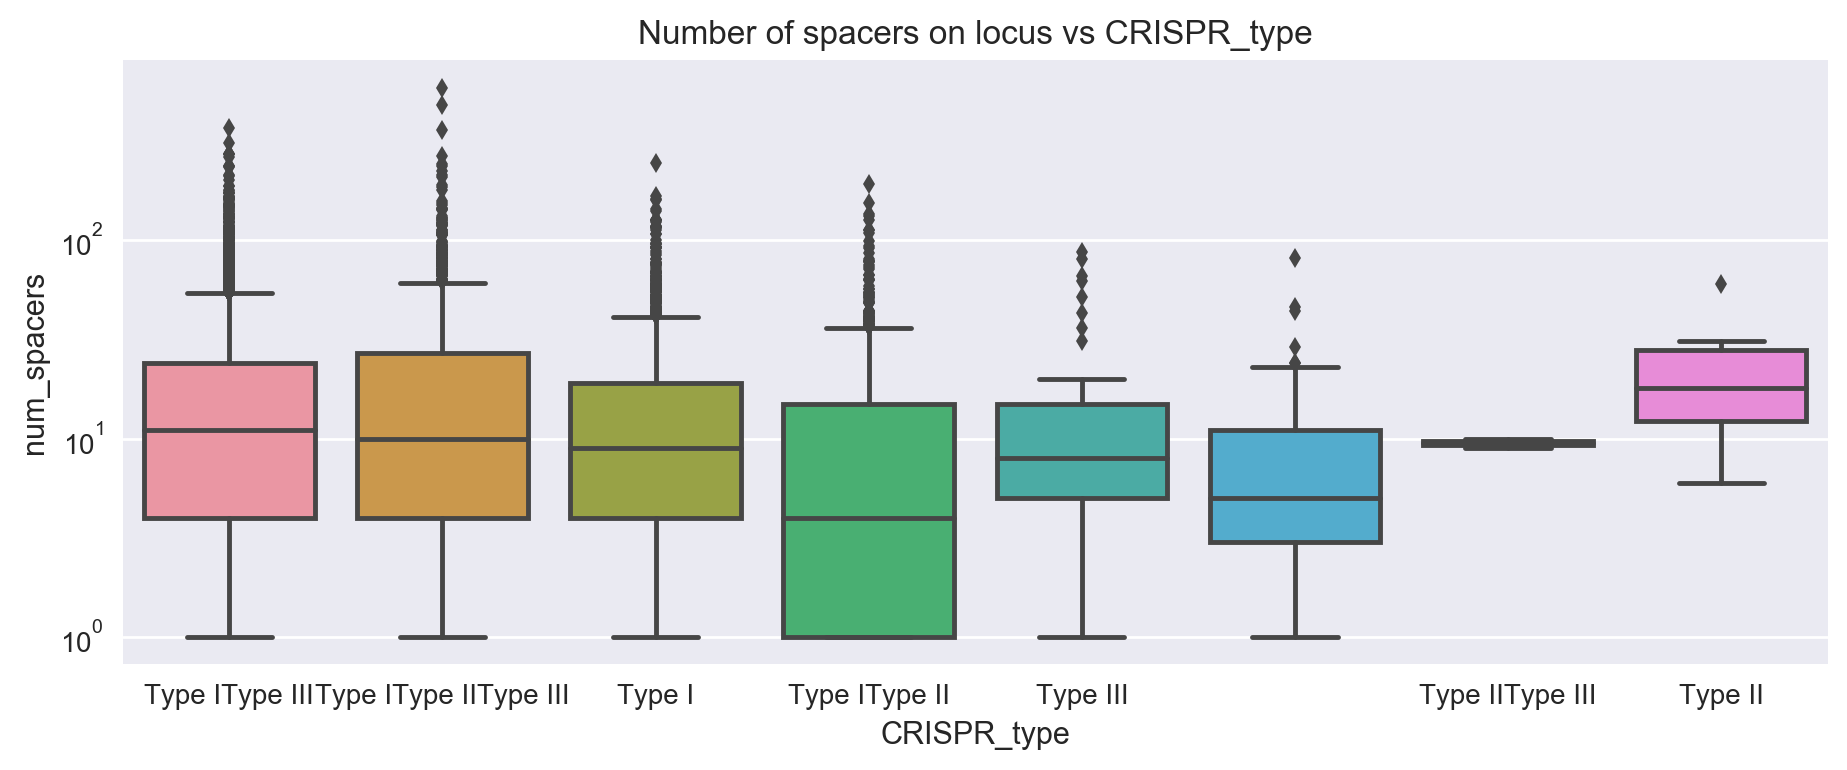

In [253]:
b=loc_df.copy()
b['CRISPR_type']=org_df.loc[b.org_id.values].CRISPR_type.values
# typegroups = b.groupby(by='CRISPR_type')
fig, ax = plt.subplots(figsize=(11,4),dpi=200)
ax.set_title('Number of spacers on locus vs CRISPR_type')
ax.set_yscale('log')
sns.boxplot(x='CRISPR_type', y='num_spacers', data=b, ax=ax)

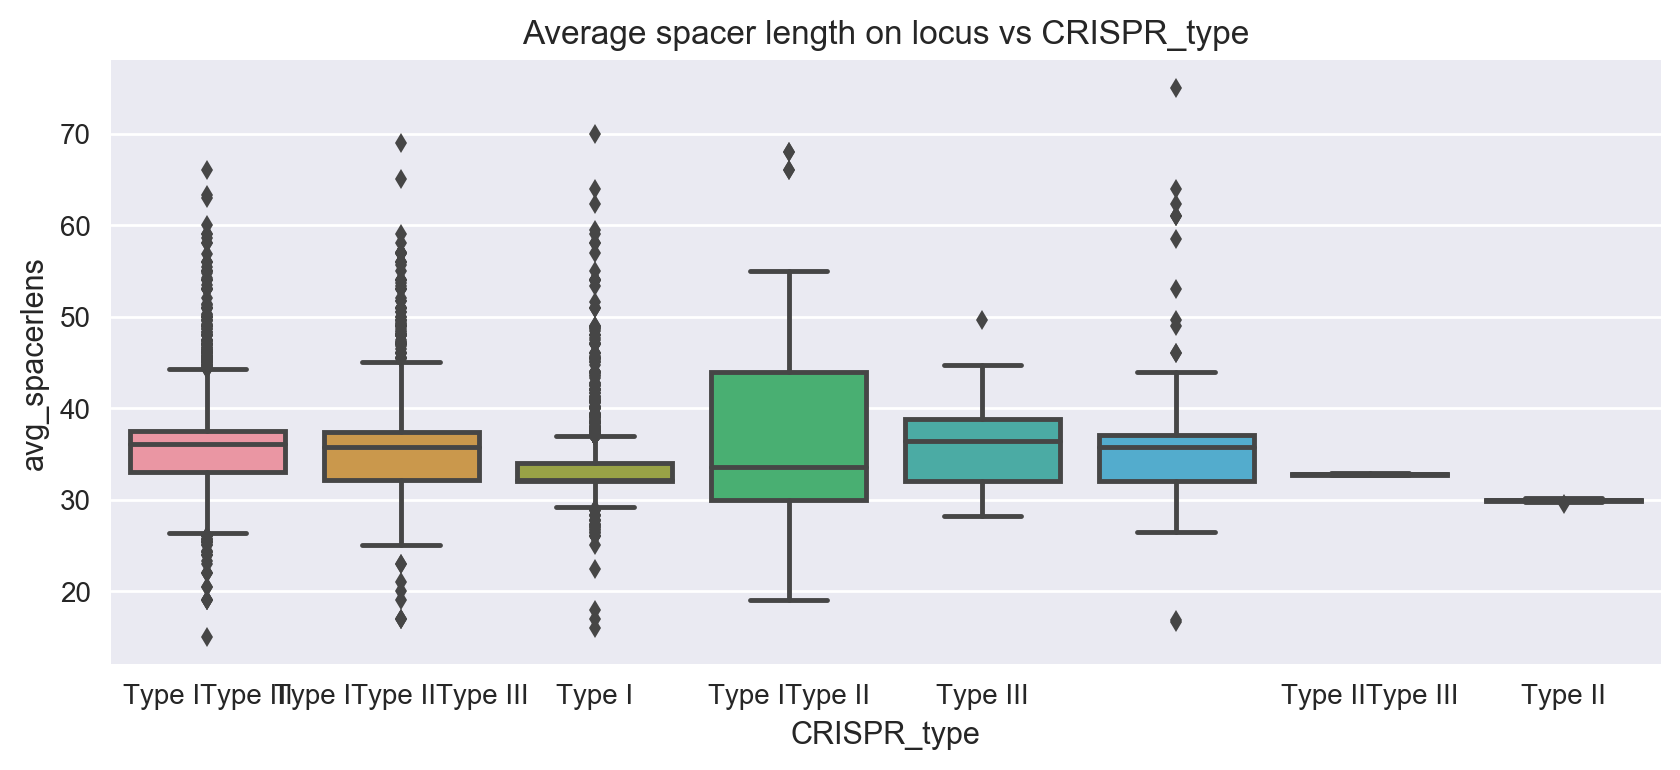

In [226]:
fig, ax = plt.subplots(figsize=(10,4),dpi=200)
ax.set_title('Average spacer length on locus vs CRISPR_type')
sns.boxplot(x='CRISPR_type', y='avg_spacerlens', data=b, ax=ax)

In [244]:
#save a genomediagram with annotated loci and cas proteins
from Bio.Graphics import GenomeDiagram
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio.SeqFeature import SeqFeature, FeatureLocation
org_id = random.choice(list(organism_dict.keys()))
org_id = 3326
max_pos=0
min_pos=1000000000
gdd = GenomeDiagram.Diagram('Test Diagram')
gdt = gdd.new_track(1, greytrack=False)
#add loci
loc_fs = gdt.new_set()
for loc in organism_dict[org_id]['loci']:
    start, end = loc['genomic_start'],loc['genomic_end']
    strand = 1
    
    if start > end:
        strand = -1
        start, end = end, start
    if end > max_pos:
        max_pos=end
    if start < min_pos:
        min_pos=start
    feature = SeqFeature(FeatureLocation(start, end), type="locus", strand=strand)
    loc_fs.add_feature(feature, name='loc'.format(loc['id']), label=True, color=colors.blue)
#add cas proteins
cas_fs = gdt.new_set()
#Iterate through each page and merge the json response into a dictionary for organismcaspairs
orgcas_dict={}
orgcas_url = url_json['organismcas']
r=requests.get(orgcas_url+'?filter{{organism}}={}'.format(org_id))
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = orgcas_url+'?page={}&filter{{organism}}={}'.format(page, org_id)
    payload = requests.get(url).json()
    orgcas_objs = payload['organism_cas_proteins']
    for orgcas_obj in orgcas_objs:
        orgcas_dict[orgcas_obj['id']] = orgcas_obj

for orgcas in orgcas_dict.values():
    if orgcas['evalue'] > 0.0200:
        continue
    start, end = orgcas['genomic_start'],orgcas['genomic_end']
    strand = 1
    if start > end:
        strand = -1
        start, end = end, start
    if end > max_pos:
        max_pos=end
    if start < min_pos:
        min_pos=start
    feature = SeqFeature(FeatureLocation(start, end), type="cas", strand=strand)
    cas_fs.add_feature(feature, name='{}'.format(cas_protein_dict[orgcas['casprotein']]['gene']), label=True)

gdd.draw(format='linear', pagesize=(15*cm,4*cm), fragments=4,
         start=min_pos, end=max_pos) 
gdd.write("{} - 002 threshold.pdf".format(org_id), "pdf")


In [252]:
#save a genomediagram with annotated loci and cas proteins
from Bio.Graphics import GenomeDiagram
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio.SeqFeature import SeqFeature, FeatureLocation
org_id = random.choice(list(organism_dict.keys()))
org_id = 365
max_pos=0
min_pos=1000000000
gdd = GenomeDiagram.Diagram('Test Diagram')
gdt = gdd.new_track(1, greytrack=False)
#add loci
loc_fs = gdt.new_set()
for loc in organism_dict[org_id]['loci']:
    start, end = loc['genomic_start'],loc['genomic_end']
    strand = 1
    
    if start > end:
        strand = -1
        start, end = end, start
    if end > max_pos:
        max_pos=end
    if start < min_pos:
        min_pos=start
    feature = SeqFeature(FeatureLocation(start, end), type="locus", strand=strand)
    loc_fs.add_feature(feature, name='loc'.format(loc['id']), label=True, color=colors.blue)
#add cas proteins
cas_fs = gdt.new_set()
#Iterate through each page and merge the json response into a dictionary for organismcaspairs
orgcas_dict={}
orgcas_url = url_json['organismcas']
r=requests.get(orgcas_url+'?filter{{organism}}={}'.format(org_id))
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = orgcas_url+'?page={}&filter{{organism}}={}'.format(page, org_id)
    payload = requests.get(url).json()
    orgcas_objs = payload['organism_cas_proteins']
    for orgcas_obj in orgcas_objs:
        orgcas_dict[orgcas_obj['id']] = orgcas_obj

for orgcas in orgcas_dict.values():
    start, end = orgcas['genomic_start'],orgcas['genomic_end']
    strand = 1
    if start > end:
        strand = -1
        start, end = end, start
    if end > max_pos:
        max_pos=end
    if start < min_pos:
        min_pos=start
    feature = SeqFeature(FeatureLocation(start, end), type="cas", strand=strand)
    cas_fs.add_feature(feature, name='{}'.format(cas_protein_dict[orgcas['casprotein']]['gene']), label=True)

gdd.draw(format='linear', pagesize=(15*cm,4*cm), fragments=4,
         start=min_pos, end=max_pos) 
gdd.write("{}.pdf".format(org_id), "pdf")


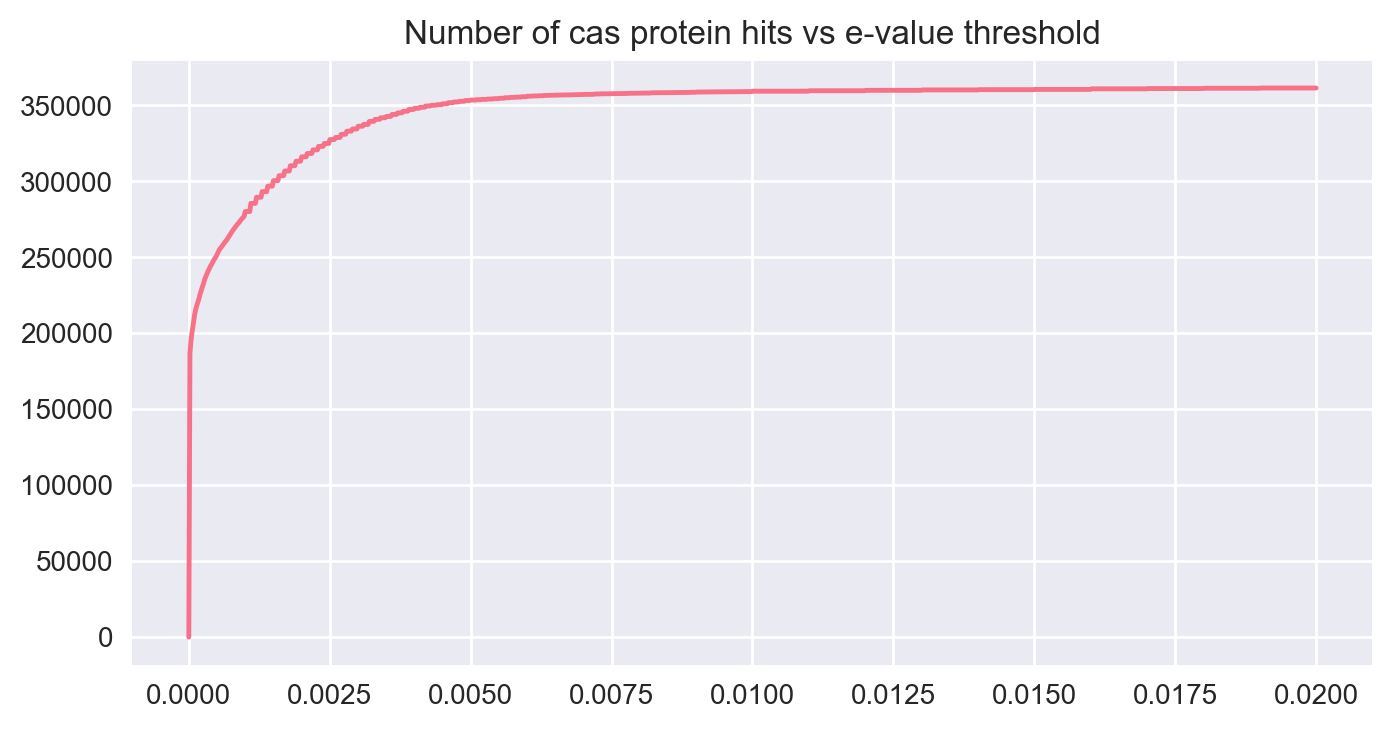

In [232]:
#plot cas protein hits vs evalue threshold
import os
import warnings
warnings.filterwarnings('ignore')
evaluehits=[]
for fn in os.listdir('../gbfiles/hmmeroutput'):
    data = np.loadtxt("../gbfiles/hmmeroutput/{}".format(fn), dtype='S')
    for row in data:  # iterate over HMMER matches to cas protein profiles
        if not data[0].shape:
            row = data
        evaluehits.append(float(row[4].decode('utf8')))
e_df = pd.DataFrame(evaluehits)
evalues = np.linspace(0,0.02,1000)
hitcounts = []
for ev in evalues:
    hitcounts.append(len(e_df[e_df<ev].dropna()))
fig, ax = plt.subplots(figsize=(8,4),dpi=200)
ax.plot(evalues,hitcounts)
ax.set_title('Number of cas protein hits vs e-value threshold')

In [234]:
orgcas_dict[104178]

{'casprotein': 374,
 'evalue': 2.9e-12,
 'genomic_end': 5679,
 'genomic_start': 3295,
 'id': 104178,
 'organism': 1354}

In [3]:
#Iterate through each page and merge the json response into a dictionary for cas proteins
oselfspacer_dict = {}
r=requests.get(oselfspacer_url)
last_page = r.json()['meta']['total_pages']
for page in range(1,last_page+1):
    url = oselfspacer_url+'?page={}'.format(page)
    payload = requests.get(url).json()
    oselfspacer_objs = payload['organism_self_spacers']
    for oselfspacer_obj in oselfspacer_objs:
        oselfspacer_dict[oselfspacer_obj['id']] = oselfspacer_obj

In [6]:
selftargeting_orgs = set( v['organism'] for v in oselfspacer_dict.values())

In [7]:
len(selftargeting_orgs)

786